In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import networkx as nx
import random
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*alltrue.*deprecated.*")

In [2]:
# Load the dataset
df = pd.read_csv("data.csv")
df

,course_type,course_round,course_date,student_id,address,amount_irr
0,sausage,2,2022-01-03,1008,shiraz,60000000
1,sausage,2,2022-01-03,1009,shiraz,60000000
2,sausage,2,2022-01-03,1010,shiraz,60000000
3,sausage,2,2022-01-03,1011,shiraz,60000000
4,sausage,2,2022-01-03,1006,shiraz,60000000
...,...,...,...,...,...,...
348,barista,18,2022-12-29,1273,shiraz,81000000
349,barista,18,2022-12-29,1274,shiraz,76000000
350,barista,18,2022-12-29,1275,shiraz,81000000
351,barista,18,2022-12-29,1276,shiraz,81000000


In [3]:
# Summary of columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   course_type   353 non-null    object
 1   course_round  353 non-null    int64 
 2   course_date   353 non-null    object
 3   student_id    353 non-null    int64 
 4   address       313 non-null    object
 5   amount_irr    353 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 16.7+ KB


In [4]:
# Missing values summary
df.isnull().sum().sort_values(ascending=False)

address         40
course_type      0
course_round     0
course_date      0
student_id       0
amount_irr       0
dtype: int64

In [5]:
# Convert 'course_date' to datetime format
df['course_date'] = pd.to_datetime(df['course_date'])

# Extract day, month, year from 'course_date'
df['day'] = df['course_date'].dt.day
df['month'] = df['course_date'].dt.month
df['year'] = df['course_date'].dt.year

# Create 'year_month' column in 'YYYY-MM' format
df['year_month'] = df['course_date'].dt.to_period('M').astype(str)

# Get day name from 'course_date'
df['day_name'] = df['course_date'].dt.day_name()

# Display updated DataFrame
df

,course_type,course_round,course_date,student_id,address,amount_irr,day,month,year,year_month,day_name
0,sausage,2,2022-01-03,1008,shiraz,60000000,3,1,2022,2022-01,Monday
1,sausage,2,2022-01-03,1009,shiraz,60000000,3,1,2022,2022-01,Monday
2,sausage,2,2022-01-03,1010,shiraz,60000000,3,1,2022,2022-01,Monday
3,sausage,2,2022-01-03,1011,shiraz,60000000,3,1,2022,2022-01,Monday
4,sausage,2,2022-01-03,1006,shiraz,60000000,3,1,2022,2022-01,Monday
...,...,...,...,...,...,...,...,...,...,...,...
348,barista,18,2022-12-29,1273,shiraz,81000000,29,12,2022,2022-12,Thursday
349,barista,18,2022-12-29,1274,shiraz,76000000,29,12,2022,2022-12,Thursday
350,barista,18,2022-12-29,1275,shiraz,81000000,29,12,2022,2022-12,Thursday
351,barista,18,2022-12-29,1276,shiraz,81000000,29,12,2022,2022-12,Thursday


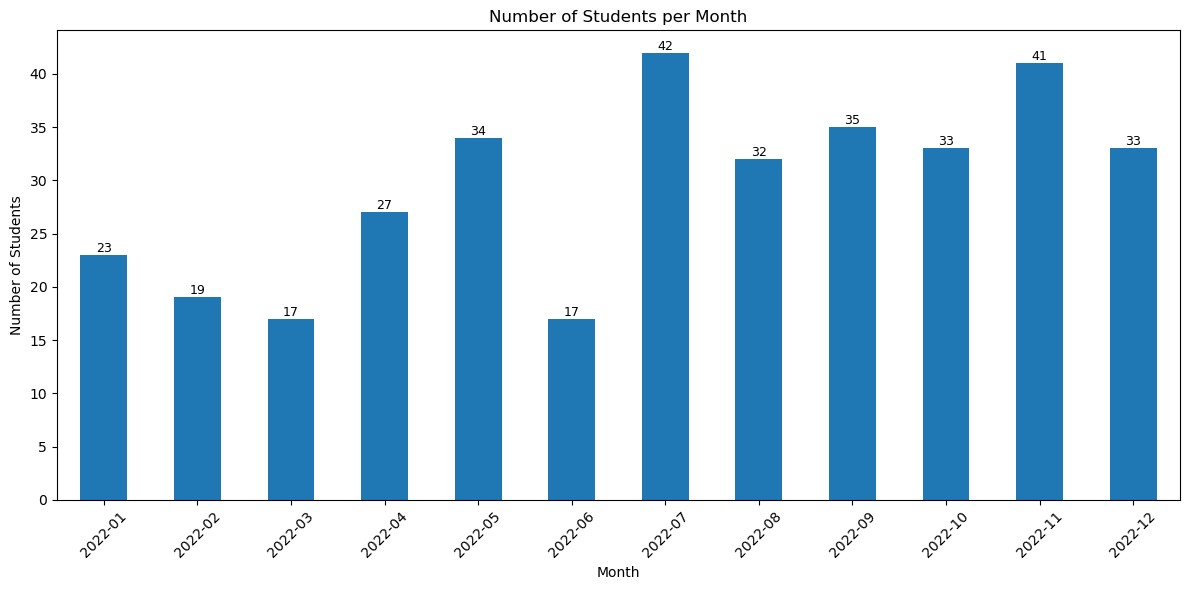

In [6]:
# Count number of students per month
monthly_counts = df['year_month'].value_counts().sort_index()

# Create bar plot
ax = monthly_counts.plot(kind='bar', figsize=(12, 6))

# Add value labels on bars
for i, value in enumerate(monthly_counts):
    ax.text(i, value + 0.005, str(value), ha='center', va='bottom', fontsize=9)

plt.xlabel('Month')
plt.ylabel('Number of Students')
plt.title('Number of Students per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

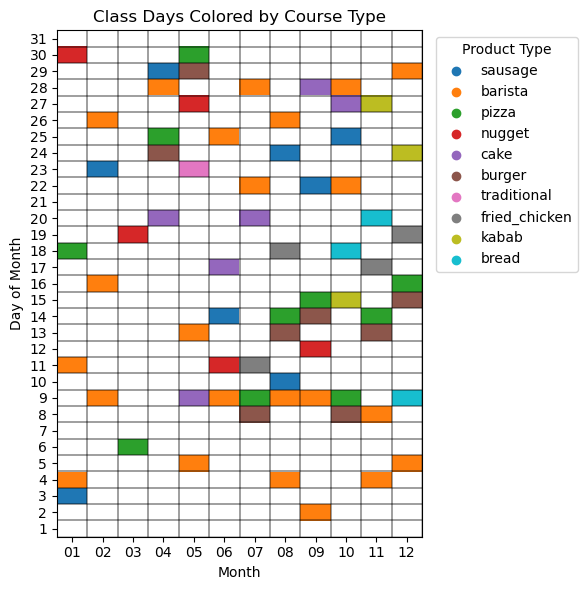

In [7]:
# Remove duplicate course dates
df_unique = df.drop_duplicates(subset=['course_date'])

# Pivot table: rows = day, columns = month, values = course_type
pivot = df_unique.pivot(index='day', columns='month', values='course_type')

# Reindex to fill missing days/months with NaN
pivot = pivot.reindex(index=range(1, 32), columns=range(1, 13), fill_value=0)
pivot = pivot.replace(0, np.nan)

# Prepare color mapping for each course type
products = df['course_type'].dropna().unique()
colors = sns.color_palette('tab10', len(products))
product_color_map = dict(zip(products, colors))

# Create RGB color array for heatmap
color_array = np.empty(pivot.shape + (3,), dtype=float)
for i, day in enumerate(pivot.index):
    for j, month in enumerate(pivot.columns):
        product = pivot.loc[day, month]
        if pd.isna(product):
            color_array[i, j] = (1, 1, 1)  # White for empty cells
        else:
            color_array[i, j] = product_color_map.get(product, (0.8, 0.8, 0.8))  # Gray fallback

# Plot calendar heatmap
plt.figure(figsize=(6, 6))
plt.imshow(color_array, aspect='auto', origin='lower', extent=[0.5, 12.5, 0.5, 31.5])

# Draw cell borders
for i in range(31):
    for j in range(12):
        plt.gca().add_patch(plt.Rectangle(
            (j + 0.5, i + 0.5), 1, 1,
            fill=False, edgecolor='black', linewidth=0.3
        ))

# Set labels and title
plt.title('Class Days Colored by Course Type')
plt.xlabel('Month')
plt.ylabel('Day of Month')
plt.xticks(ticks=range(1, 13), labels=[str(i).zfill(2) for i in range(1, 13)])
plt.yticks(ticks=range(1, 32), labels=[str(i) for i in range(1, 32)])

# Add legend for course types
for product, color in product_color_map.items():
    plt.scatter([], [], color=color, label=product)
plt.legend(title='Product Type', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

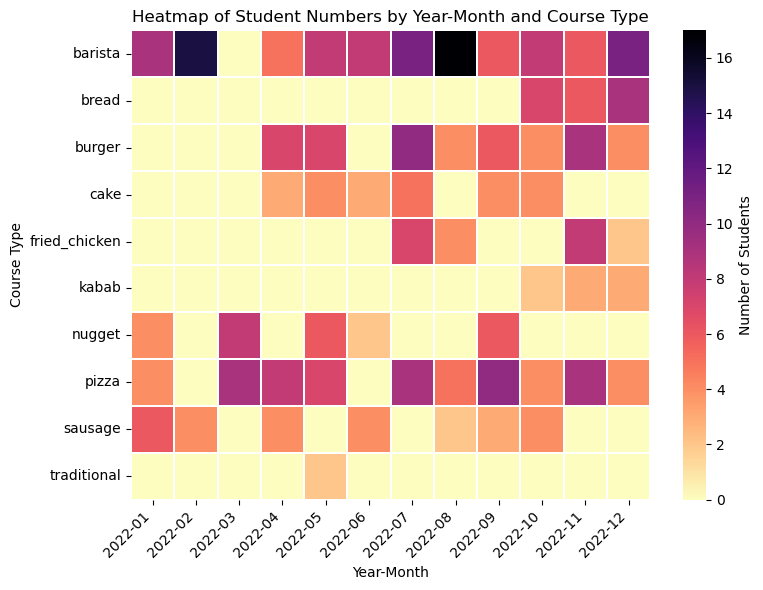

In [8]:
# Count students per year-month and course type
student_counts = df.groupby(['year_month', 'course_type'])['student_id'].count().reset_index()

# Create pivot table for heatmap (rows = course type, columns = year-month)
pivot_table = student_counts.pivot(index='year_month', columns='course_type', values='student_id').T
pivot_heatmap = pivot_table.fillna(0)

# Plot heatmap of student numbers
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_heatmap, cmap='magma_r', linewidths=0.3, cbar_kws={"label": "Number of Students"})  # annot=True, fmt='.0f'

# Customise plot
plt.title('Heatmap of Student Numbers by Year-Month and Course Type')
plt.xlabel('Year-Month')
plt.ylabel('Course Type')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

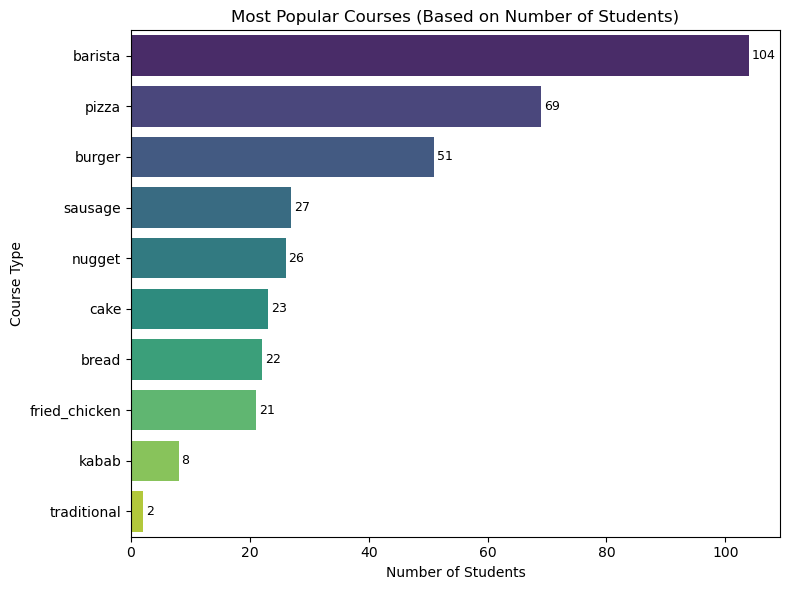

In [9]:
# Count number of students per course type
course_popularity = df['course_type'].value_counts().reset_index()
course_popularity.columns = ['course_type', 'student_count']

# Plot horizontal bar chart of course popularity
plt.figure(figsize=(8, 6))
sns.barplot(data=course_popularity, x='student_count', y='course_type', palette='viridis')

# Add chart title and labels
plt.title('Most Popular Courses (Based on Number of Students)')
plt.xlabel('Number of Students')
plt.ylabel('Course Type')
plt.tight_layout()

# Add value labels to bars
for index, row in course_popularity.iterrows():
    plt.text(row['student_count'] + 0.5, index, int(row['student_count']), va='center', fontsize=9)

plt.show()

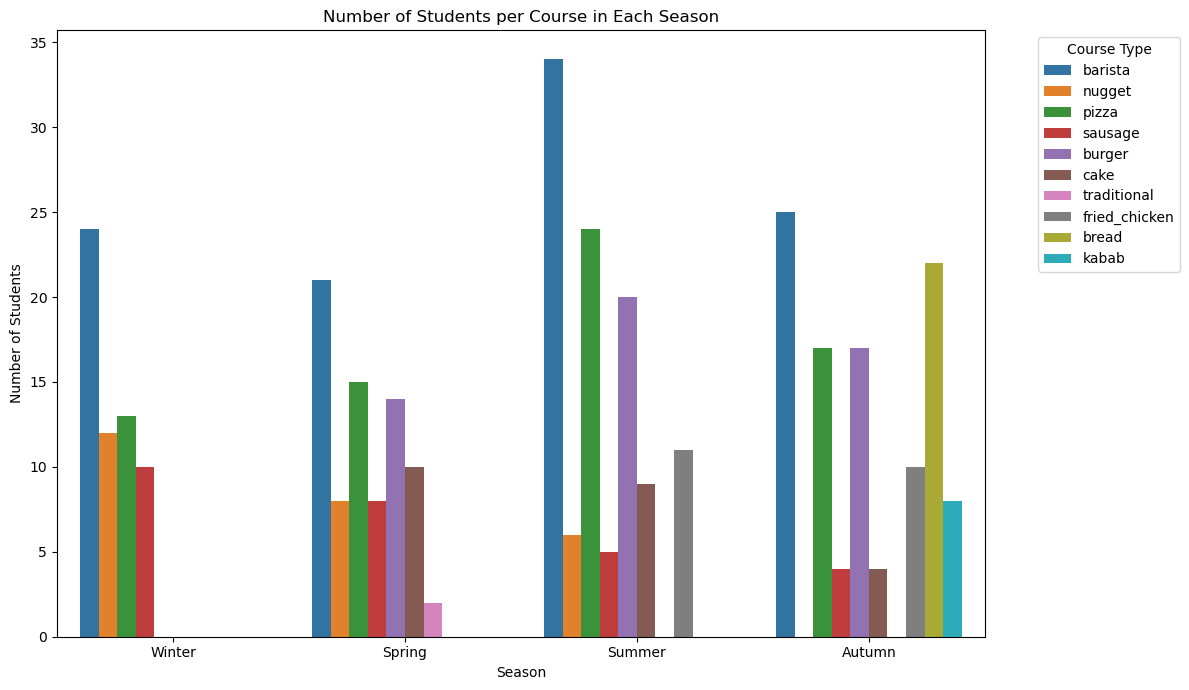

In [10]:
# Define a function to determine the season based on the Gregorian month
def get_season(month):
    if month in [4, 5, 6]:
        return 'Spring'
    elif month in [7, 8, 9]:
        return 'Summer'
    elif month in [10, 11, 12]:
        return 'Autumn'
    else:
        return 'Winter'

# Add the season column to the DataFrame
df['season'] = df['course_date'].dt.month.apply(get_season)

# Season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)

# Count the number of students for each course and each season
season_course_counts = df.groupby(['season', 'course_type'], observed=True)['student_id'].count().reset_index()
season_course_counts.rename(columns={'student_id': 'student_count'}, inplace=True)

# Grouped barplot
plt.figure(figsize=(12, 7))
sns.barplot(data=season_course_counts, x='season', y='student_count', hue='course_type', palette='tab10')

plt.title('Number of Students per Course in Each Season')
plt.xlabel('Season')
plt.ylabel('Number of Students')
plt.legend(title='Course Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

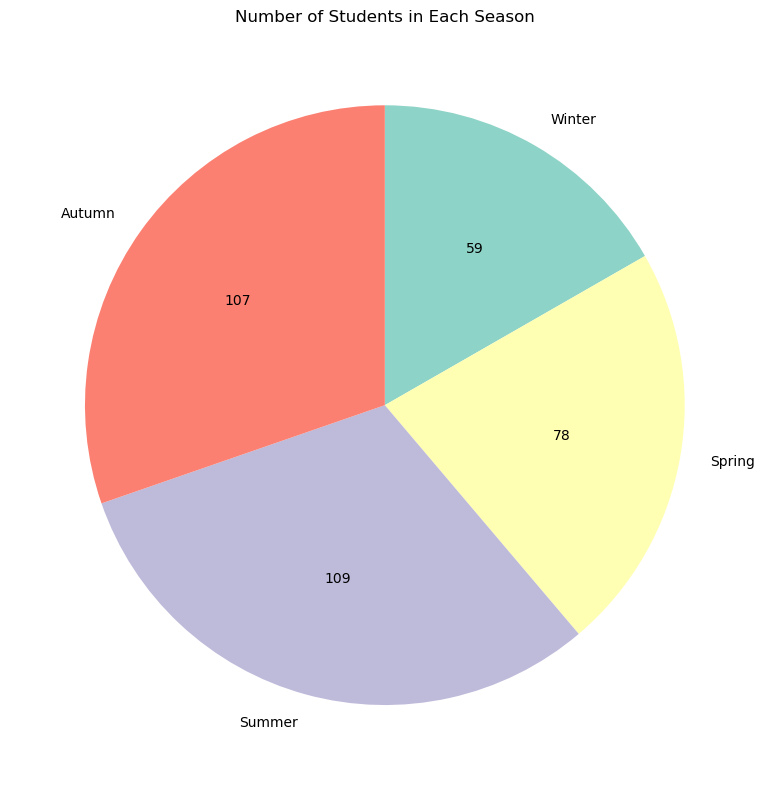

In [11]:
# Calculate total number of students per season
season_total = df.groupby('season', observed=True)['student_id'].count().reindex(season_order)

# Function to display actual values instead of percentages
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}'
    return my_autopct

# Plot pie chart of student distribution by season
plt.figure(figsize=(8, 8))
plt.pie(season_total, labels=season_total.index, autopct=make_autopct(season_total), startangle=90, counterclock=False, colors=plt.get_cmap('Set3').colors)
plt.title('Number of Students in Each Season')
plt.tight_layout()
plt.show()

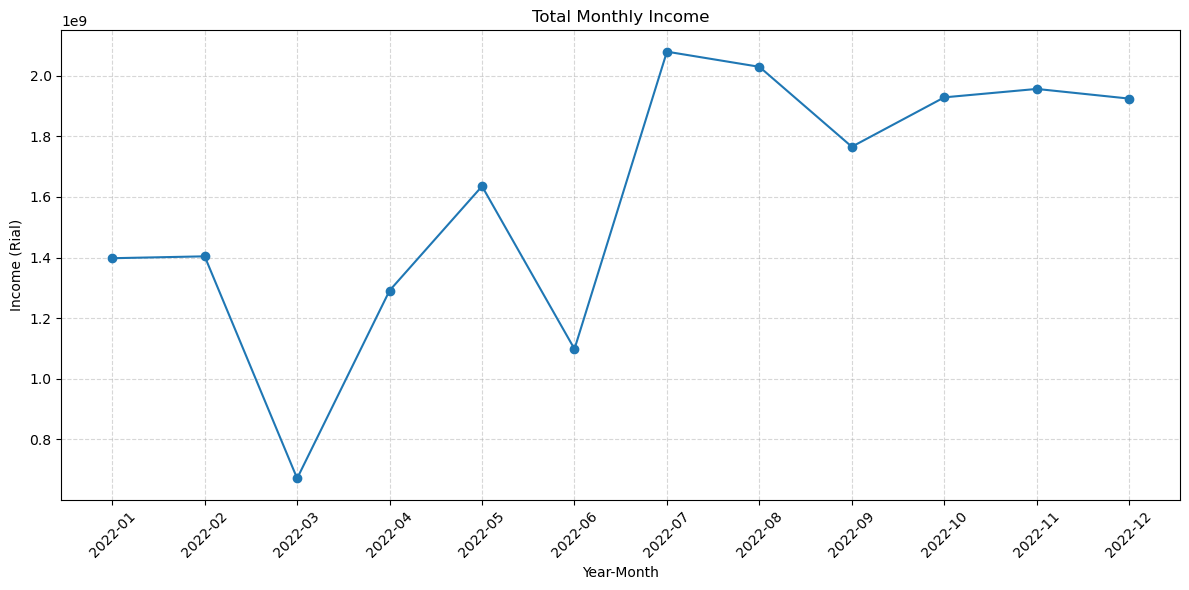

In [12]:
# Total income for each month
monthly_income = df.groupby('year_month')['amount_irr'].sum().reset_index()

# Plot monthly income as a line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_income['year_month'], monthly_income['amount_irr'], marker='o')
plt.title('Total Monthly Income')
plt.xlabel('Year-Month')
plt.ylabel('Income (Rial)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

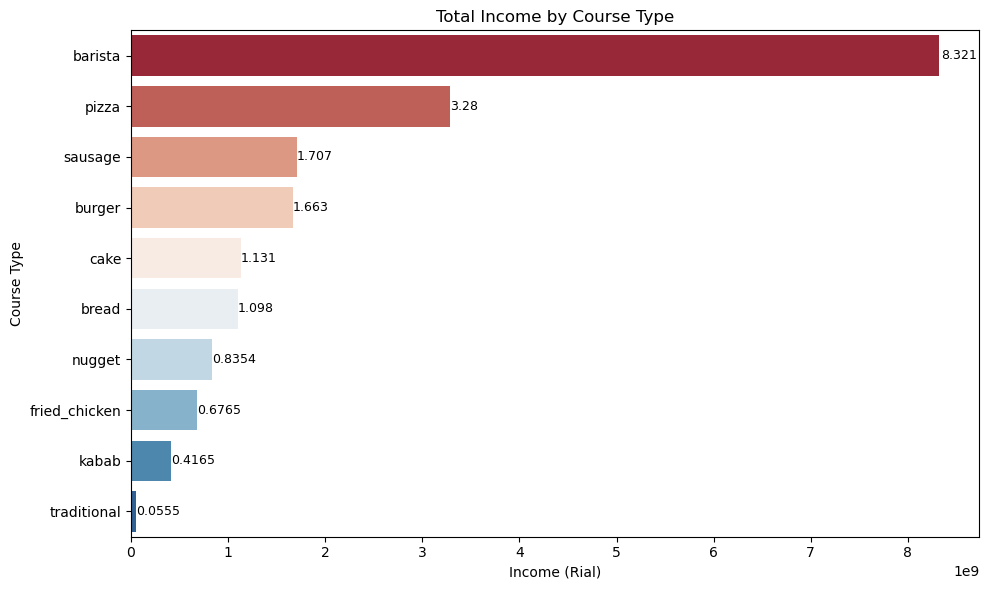

In [13]:
# Total income for each course type
course_income = df.groupby('course_type')['amount_irr'].sum().reset_index().sort_values('amount_irr', ascending=False)

# Plot horizontal bar chart of income by course type
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=course_income, y='course_type', x='amount_irr', palette='RdBu')

plt.title('Total Income by Course Type')
plt.xlabel('Income (Rial)')
plt.ylabel('Course Type')

# Add income values to bars (in billions)
for index, row in enumerate(course_income.itertuples()):
    ax.text(row.amount_irr * 1.002, index, f"{int(row.amount_irr)/1e9}", va='center', fontsize=9)
    
plt.tight_layout()
plt.show()

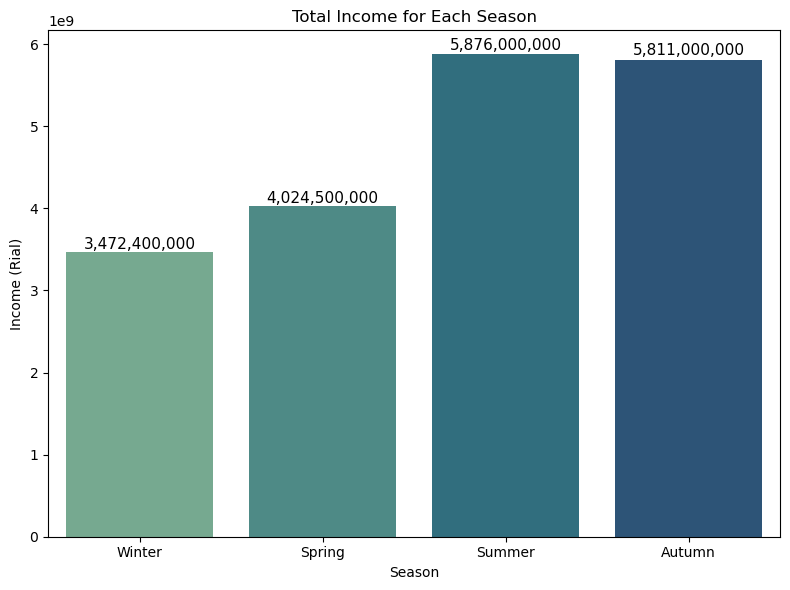

In [14]:
# Total income for each season with correct season order
season_income = df.groupby('season', observed=True)['amount_irr'].sum().reindex(season_order).reset_index()

# Plot seasonal income as a bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=season_income, x='season', y='amount_irr', palette='crest')

plt.title('Total Income for Each Season')
plt.xlabel('Season')
plt.ylabel('Income (Rial)')

# Add income value above each bar
for i, row in season_income.iterrows():
    ax.text(i, row['amount_irr'] + row['amount_irr'] * 0.01, f"{int(row['amount_irr']):,}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

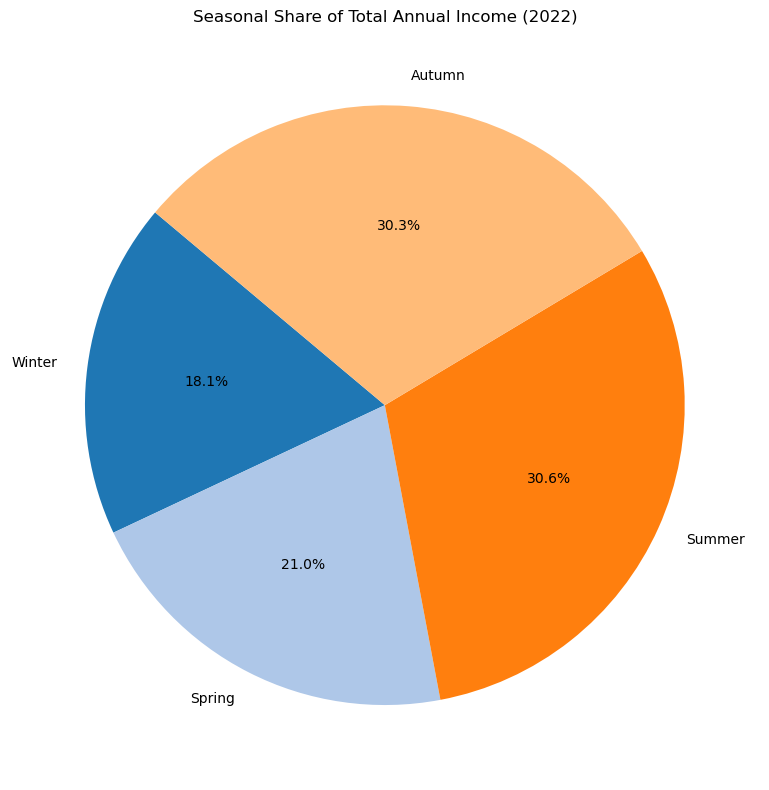

In [15]:
# Plot pie chart showing each season's share of total annual income
plt.figure(figsize=(8, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.pie(season_income['amount_irr'], labels=season_income['season'], autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('tab20').colors)
plt.title("Seasonal Share of Total Annual Income (2022)")
plt.tight_layout()
plt.show()

In [16]:
# Calculate the total income for the year 2022
total_income = season_income['amount_irr'].sum()
print(f"{total_income:,}")

19,183,900,000


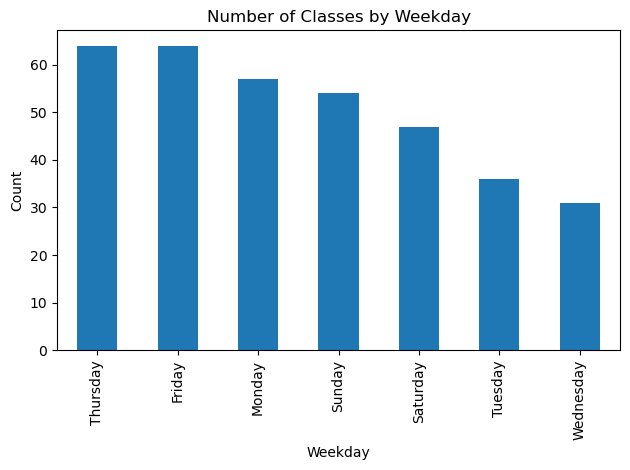

In [17]:
# Count number of classes for each weekday
day_counts = df['day_name'].value_counts()

# Plot bar chart of class counts by weekday
day_counts.plot(kind='bar')
plt.title('Number of Classes by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [18]:
# Define region groups and their corresponding cities
city_groups = {
    'shiraz': ['shiraz'],
    'fars': [
        'safashahr', 'eghlid', 'marvdasht', 'zarghan', 'kazeroon', 'firoozabad', 'kavar', 'kharameh',
        'jahrom', 'estahban', 'meymand', 'neyriz', 'farashband', 'mohr', 'maghar', 'darab', 'juyom',
        'lamerd', 'arsanjan', 'khonj', 'ardakan', 'larestan', 'vorabad', 'fasa', 'ghaderabad',
        'abadeh', 'zarrindasht', 'sarvestan', 'saadat_shahr', 'dasht_arzhan', 'ahl', 'ashkanan', 'goyem',
        'pasargard', 'atashkadeh',
    ],
    'hormozgan': ['bandarabbas', 'qeshm', 'bastak', 'kharg', 'kish'],
    'bushehr': ['bushehr', 'genaveh', 'borazjan', 'jam'],
    'kohgiluyeh\nand boyerahmad': ['yasuj', 'gachsaran'],
    'kerman': ['kerman', 'sirjan', 'meymand'],
    'golestan': ['golestan'],
    'khuzestan': ['ahvaz', 'behbahan'],
    'yazd': ['yazd'],
    'abroad': ['england'],
    'undefined': [None]
}

# Create a reverse mapping: city name  region group
city_to_group = {}
for group, cities in city_groups.items():
    for city in cities:
        if city is not None:
            city_to_group[city] = group

# Function to get region group for a given city
def get_city_group(city):
    # If city exists in city_to_group, return its group; otherwise, return 'unknown'
    return city_to_group.get(str(city).lower(), 'unknown')

# Map each address to its region group
df['region_group'] = df['address'].apply(get_city_group)
df['region_group']

0      shiraz
1      shiraz
2      shiraz
3      shiraz
4      shiraz
        ...  
348    shiraz
349    shiraz
350    shiraz
351    shiraz
352    shiraz
Name: region_group, Length: 353, dtype: object

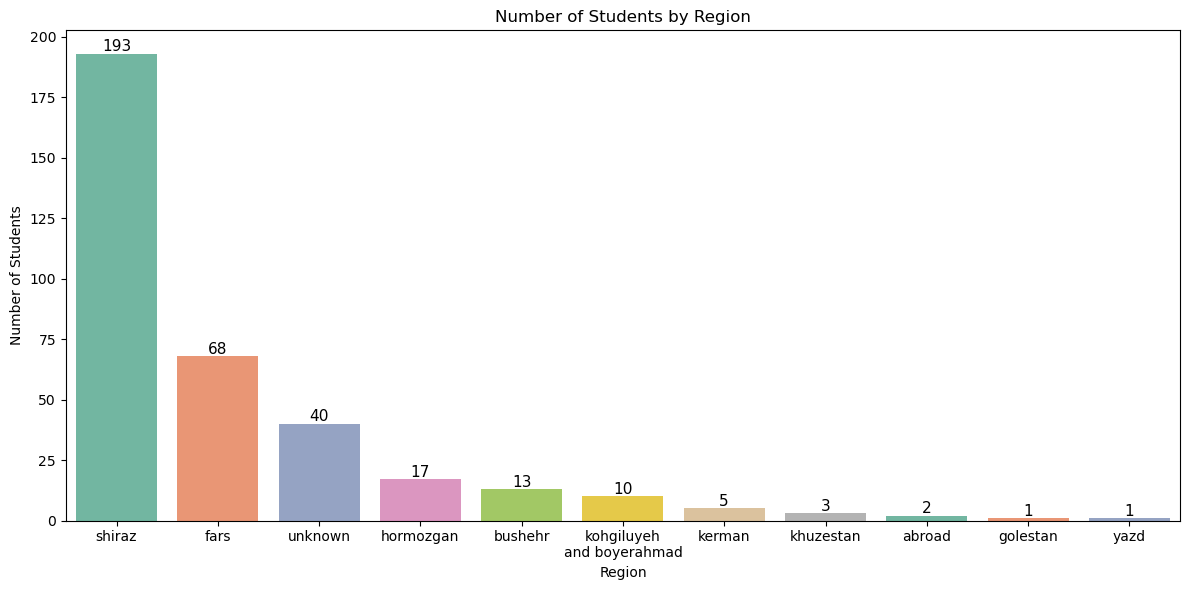

In [19]:
# Count the number of students in each region
region_student_count = df['region_group'].value_counts().reset_index()
region_student_count.columns = ['region_group', 'student_count']

# Plot a bar chart of student counts by region
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=region_student_count, x='region_group', y='student_count', palette='Set2')

plt.title('Number of Students by Region')
plt.xlabel('Region')
plt.ylabel('Number of Students')

# Show the value on top of each bar
for i, row in region_student_count.iterrows():
    ax.text(i, row['student_count'] + 1, str(row['student_count']), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

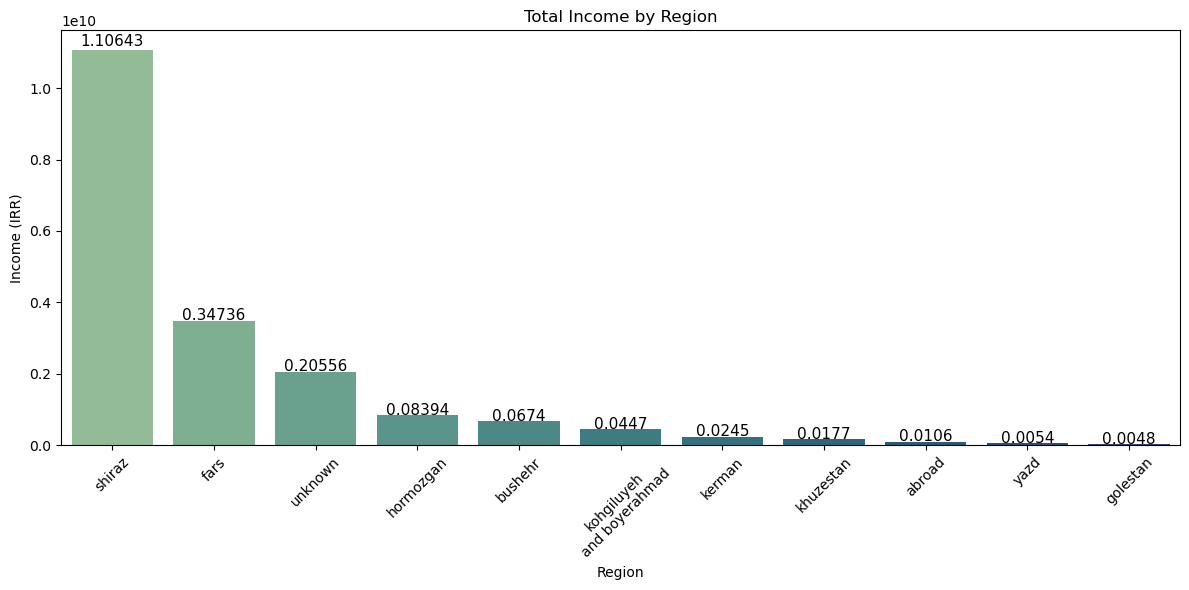

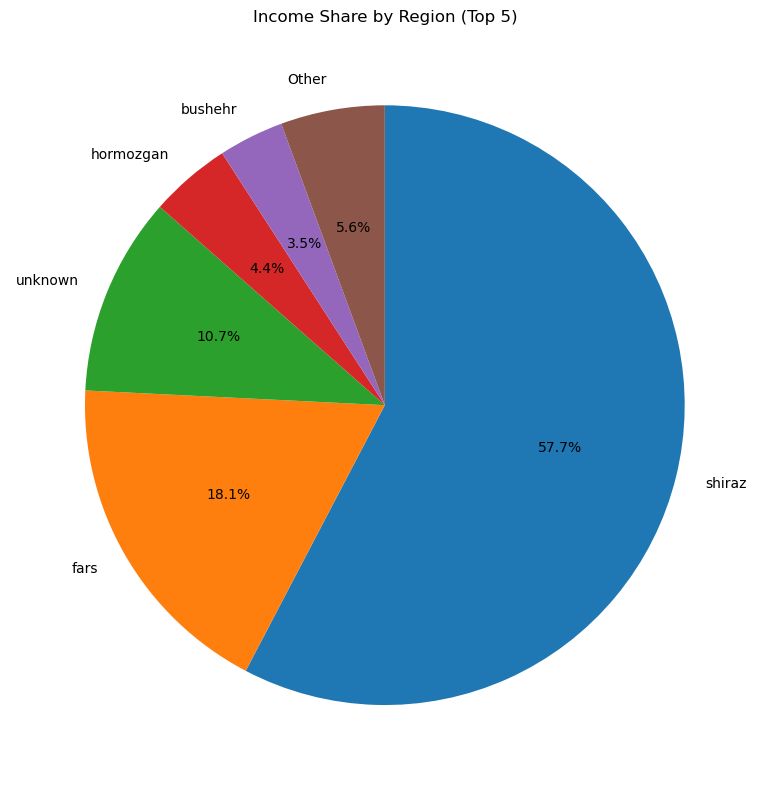

In [20]:
# Calculate the total income for each region
region_income = df.groupby('region_group')['amount_irr'].sum().sort_values(ascending=False).reset_index()

# Plot bar chart of total income by region
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=region_income, x='region_group', y='amount_irr', palette='crest')

plt.title('Total Income by Region')
plt.xlabel('Region')
plt.ylabel('Income (IRR)')
plt.xticks(rotation=45)

# Add the income value on top of each bar
for i, row in region_income.iterrows():
    ax.text(i, row['amount_irr'] * 1.01, f"{int(row['amount_irr'])/1e10}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# Prepare data for pie chart (Top 5 regions + Other)
top_n = 5
top_regions = region_income.iloc[:top_n]
other_sum = region_income.iloc[top_n:]['amount_irr'].sum()
pie_labels = list(top_regions['region_group']) + ['Other']
pie_values = list(top_regions['amount_irr']) + [other_sum]

# Plot pie chart of income share by region
plt.figure(figsize=(8, 8))
plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Income Share by Region (Top 5)')
plt.tight_layout()
plt.show()

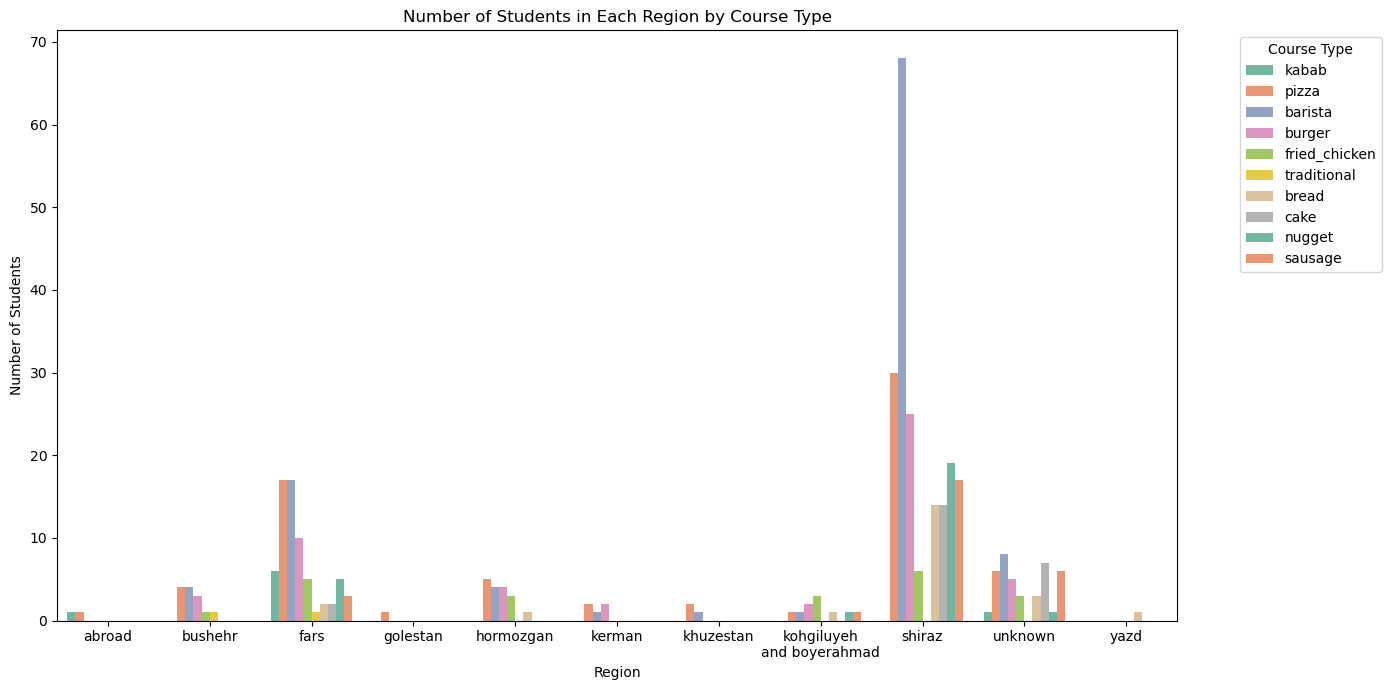

In [21]:
# Count the number of students for each region and each course type
grouped_counts = df.groupby(['region_group', 'course_type'])['student_id'].count().reset_index()

# Plot grouped bar chart of student counts by region and course type
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=grouped_counts,
    x='region_group',
    y='student_id',
    hue='course_type',
    palette='Set2'
)

plt.title('Number of Students in Each Region by Course Type')
plt.xlabel('Region')
plt.ylabel('Number of Students')
plt.legend(title='Course Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

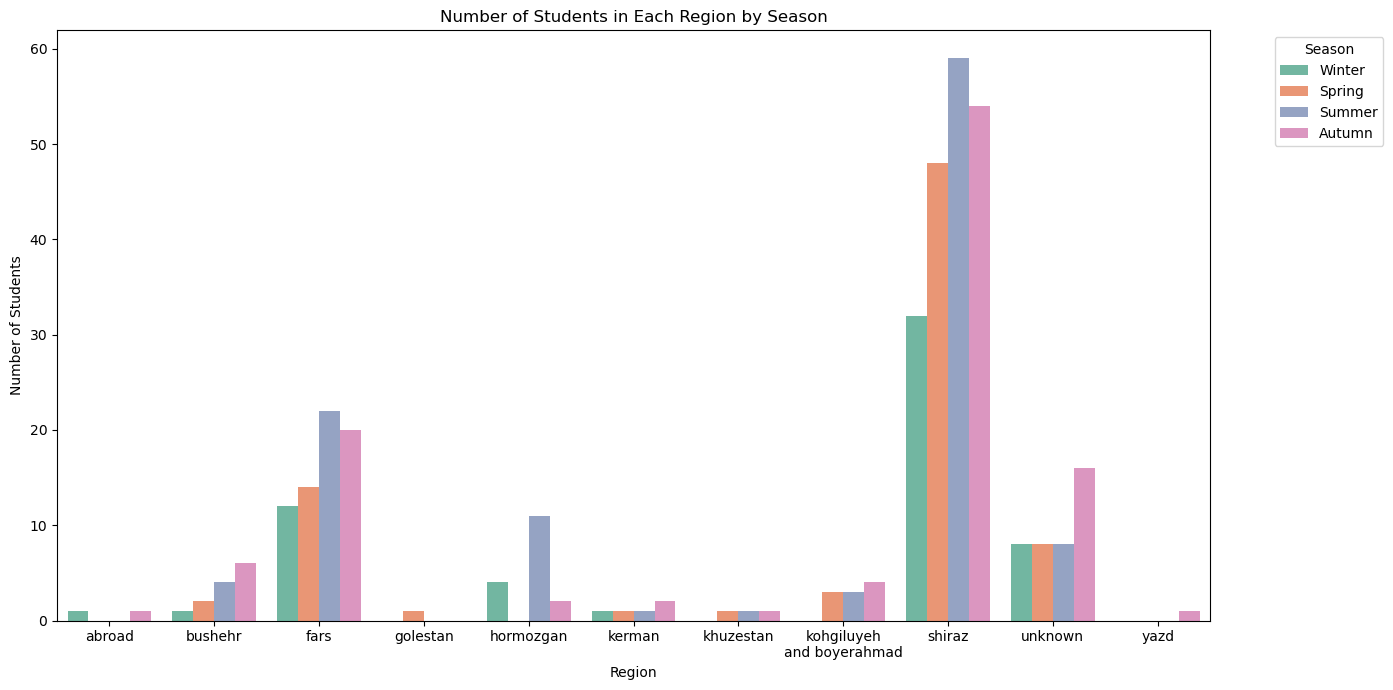

In [22]:
# Count the number of students for each region and each season
grouped_counts = df.groupby(['region_group', 'season'])['student_id'].count().reset_index()

# Plot grouped bar chart of student counts by region and season
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=grouped_counts,
    x='region_group',
    y='student_id',
    hue='season',
    palette='Set2'
)

plt.title('Number of Students in Each Region by Season')
plt.xlabel('Region')
plt.ylabel('Number of Students')
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

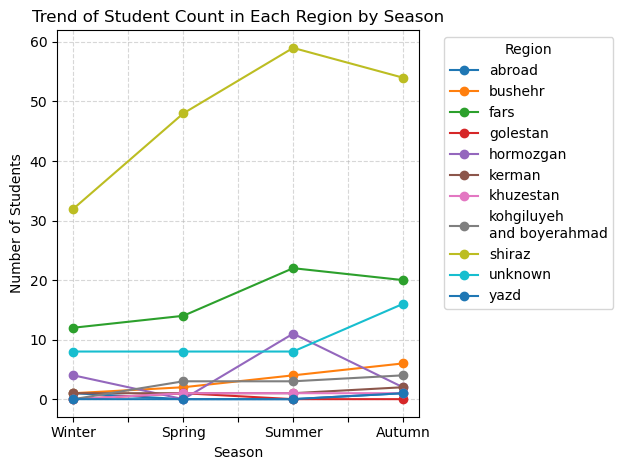

In [23]:
# Count the number of students by season and region
trend_data = df.groupby(['season', 'region_group'])['student_id'].count().reset_index()

# Pivot table: seasons as index, regions as columns
pivot_trend = trend_data.pivot(index='season', columns='region_group', values='student_id')

# Reorder of seasons for better display
pivot_trend = pivot_trend.reindex(season_order)

# Plot line chart of student trends by season and region
pivot_trend.plot(marker='o')
plt.title('Trend of Student Count in Each Region by Season')
plt.xlabel('Season')
plt.ylabel('Number of Students')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

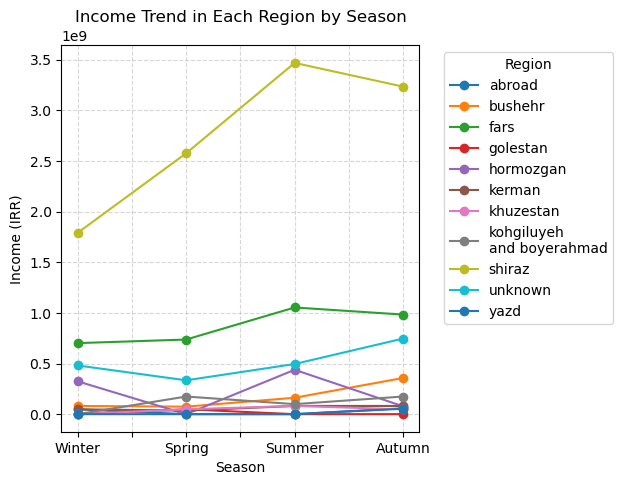

In [24]:
# Sum of income by region and season
trend_income = df.groupby(['season', 'region_group'])['amount_irr'].sum().reset_index()

# Pivot so that each region appears as a line
pivot_income = trend_income.pivot(index='season', columns='region_group', values='amount_irr')

# Order of seasons
pivot_income = pivot_income.reindex(season_order)

# Plot income trend as line chart
pivot_income.plot(marker='o')
plt.title('Income Trend in Each Region by Season')
plt.xlabel('Season')
plt.ylabel('Income (IRR)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

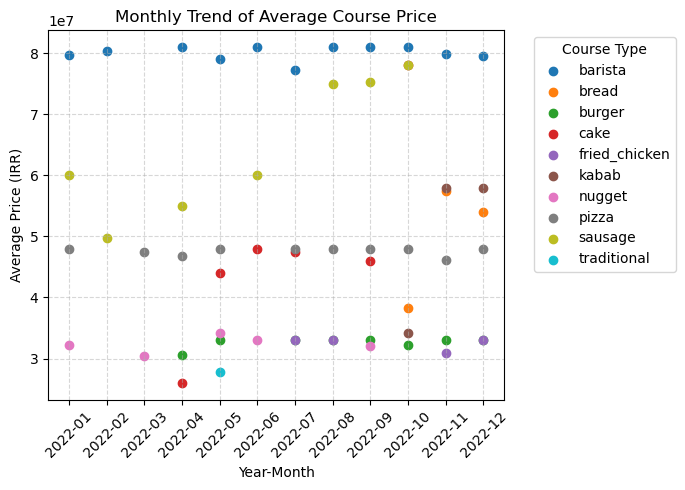

In [25]:
# Average price of each course type per month
avg_price = df.groupby(['year_month', 'course_type'])['amount_irr'].mean().reset_index()

# Pivot table: rows = year-month, columns = course type, values = average price
pivot_price = avg_price.pivot(index='year_month', columns='course_type', values='amount_irr')

# Plot average course prices over time using scatter plot
plt.figure(figsize=(7, 5))

for col in pivot_price.columns:
    plt.scatter(pivot_price.index, pivot_price[col], label=col)

plt.title('Monthly Trend of Average Course Price')
plt.xlabel('Year-Month')
plt.ylabel('Average Price (IRR)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Course Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

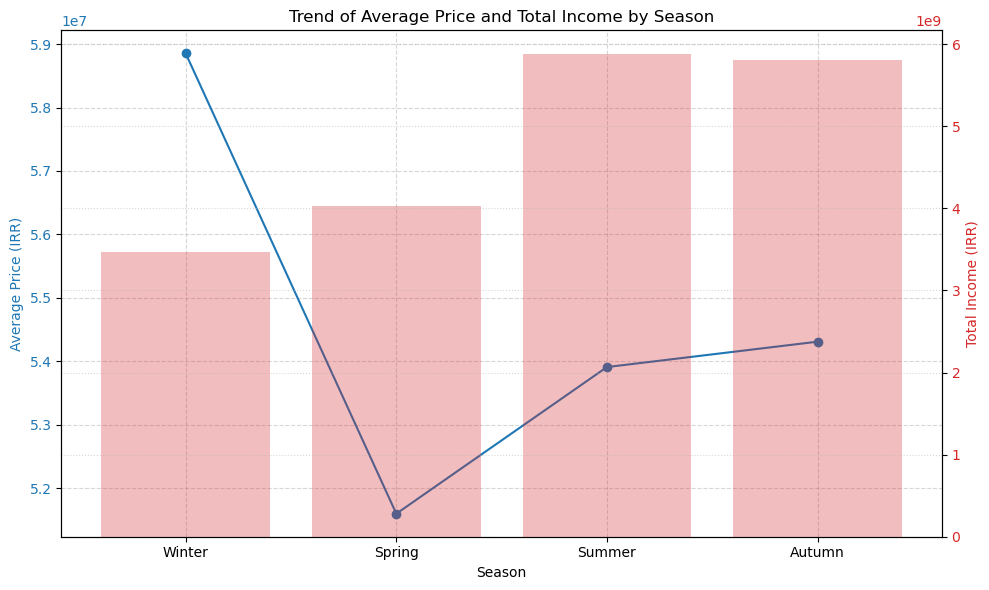

In [26]:
# Calculate the average price and total income per season
season_stats = df.groupby('season').agg(
    mean_price=('amount_irr', 'mean'),
    total_income=('amount_irr', 'sum')
).reindex(season_order)

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot average price (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Season')
ax1.set_ylabel('Average Price (IRR)', color=color)
ax1.plot(season_stats.index, season_stats['mean_price'], color=color, marker='o', label='Average Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot total income (right y-axis)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Income (IRR)', color=color)
ax2.bar(season_stats.index, season_stats['total_income'], alpha=0.3, color=color, label='Total Income')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, linestyle=':', alpha=0.5)

plt.title('Trend of Average Price and Total Income by Season')
fig.tight_layout()
plt.show()

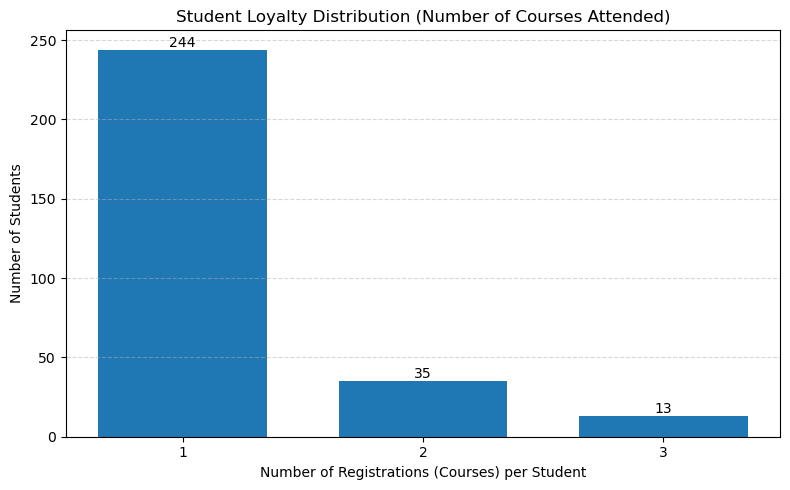

In [27]:
# Count how many times each student registered
student_counts = df['student_id'].value_counts()

# Count how many students fall into each registration count
loyalty_dist = student_counts.value_counts().sort_index()

# Plot bar chart of student loyalty distribution
plt.figure(figsize=(8, 5))
bars = plt.bar(loyalty_dist.index, loyalty_dist.values, width=0.7)
plt.xlabel('Number of Registrations (Courses) per Student')
plt.ylabel('Number of Students')
plt.title('Student Loyalty Distribution (Number of Courses Attended)')
plt.xticks(loyalty_dist.index)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Annotate bars with values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()

In [28]:
# Sort data by student and date
df_sorted = df.sort_values(['student_id', 'course_date'])

# Create a string pattern of course sequence for each student
seq = df_sorted.groupby('student_id')['course_type'].apply(lambda x: ' -> '.join(x)).reset_index()
seq.columns = ['student_id', 'course_sequence']

# Calculate the number of courses in each sequence
seq['seq_length'] = seq['course_sequence'].str.count('->') + 1

# Only sequences with length > 1 (more than one course)
multi_seq = seq[seq['seq_length'] > 1]

# Count the number of students for each sequence
patterns = multi_seq['course_sequence'].value_counts().reset_index()
patterns.columns = ['sequence', 'student_count']

print(patterns)

                            sequence  student_count
0                    burger -> pizza             20
1                  sausage -> nugget              5
2   burger -> pizza -> fried_chicken              5
3         burger -> pizza -> barista              3
4                  nugget -> sausage              2
5                     kabab -> kabab              2
6                    barista -> cake              1
7                     pizza -> kabab              1
8                   barista -> bread              1
9        sausage -> nugget -> burger              1
10                  nugget -> burger              1
11        barista -> burger -> pizza              1
12  fried_chicken -> burger -> pizza              1
13  fried_chicken -> pizza -> burger              1
14                sausage -> sausage              1
15                barista -> barista              1
16          kabab -> burger -> pizza              1


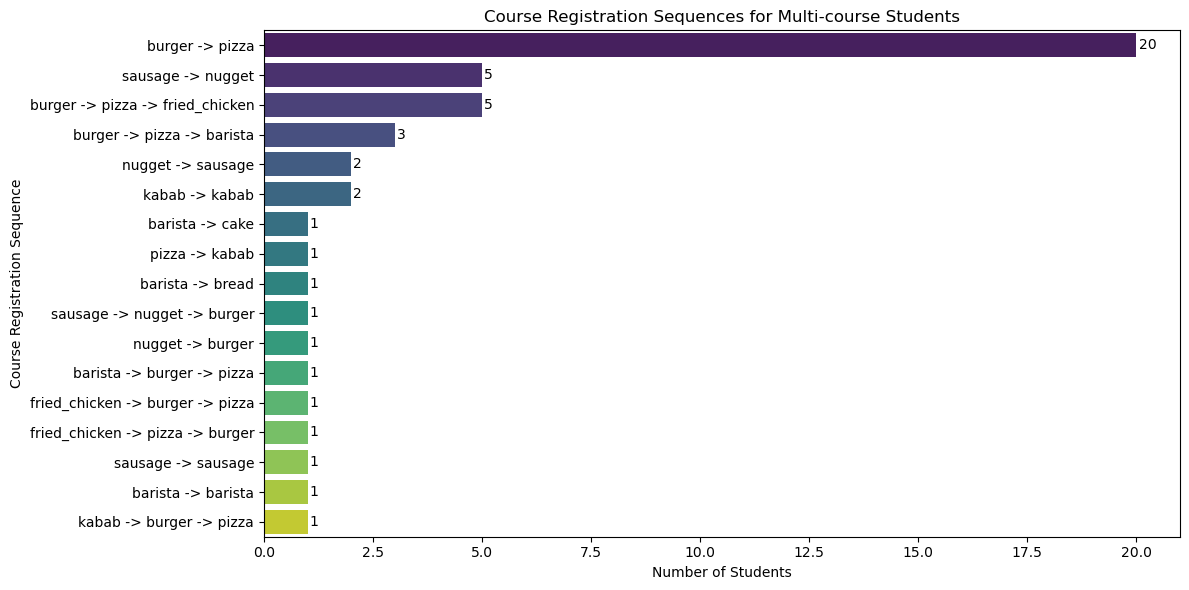

In [29]:
# Plot bar chart of course registration sequences (multi-course students only)
plt.figure(figsize=(12,6))
ax = sns.barplot(data=patterns, y='sequence', x='student_count', palette='viridis')

plt.title('Course Registration Sequences for Multi-course Students')
plt.xlabel('Number of Students')
plt.ylabel('Course Registration Sequence')
plt.tight_layout()

# Add student count labels next to bars
for p in ax.patches:
    plt.text(p.get_width() + 0.05, p.get_y() + p.get_height()/2, int(p.get_width()), va='center')

plt.show()

---- Sequences with 2 Courses ----
             sequence  student_count
0     burger -> pizza             20
1   sausage -> nugget              5
2   nugget -> sausage              2
3      kabab -> kabab              2
4     barista -> cake              1
5      pizza -> kabab              1
6    barista -> bread              1
7    nugget -> burger              1
8  sausage -> sausage              1
9  barista -> barista              1


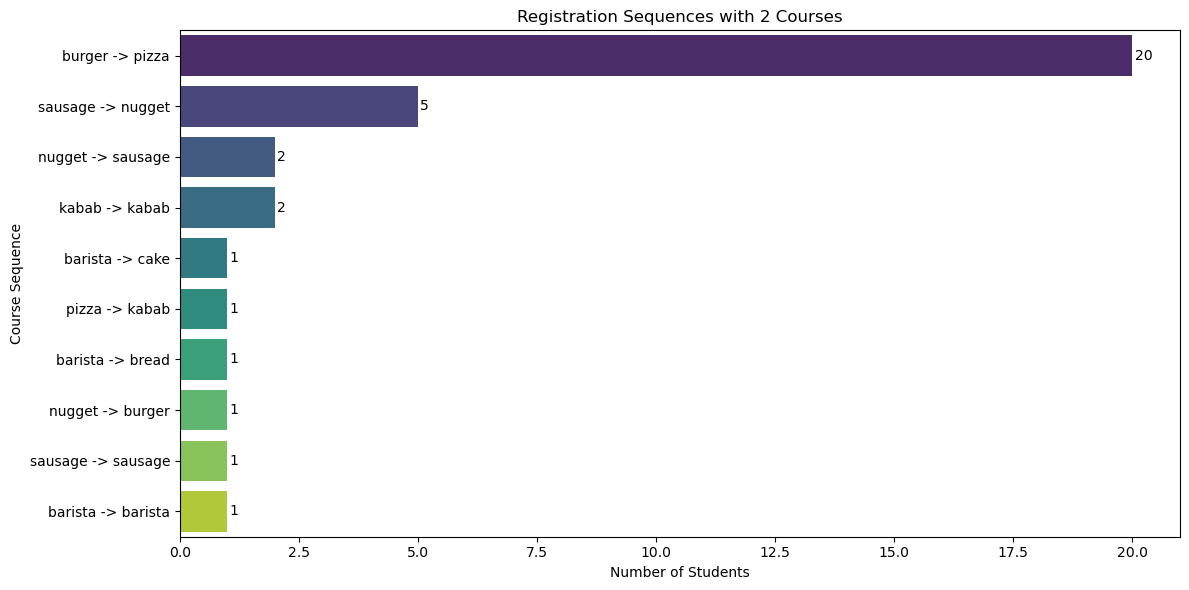

---- Sequences with 3 Courses ----
                           sequence  student_count
0  burger -> pizza -> fried_chicken              5
1        burger -> pizza -> barista              3
2       sausage -> nugget -> burger              1
3        barista -> burger -> pizza              1
4  fried_chicken -> burger -> pizza              1
5  fried_chicken -> pizza -> burger              1
6          kabab -> burger -> pizza              1


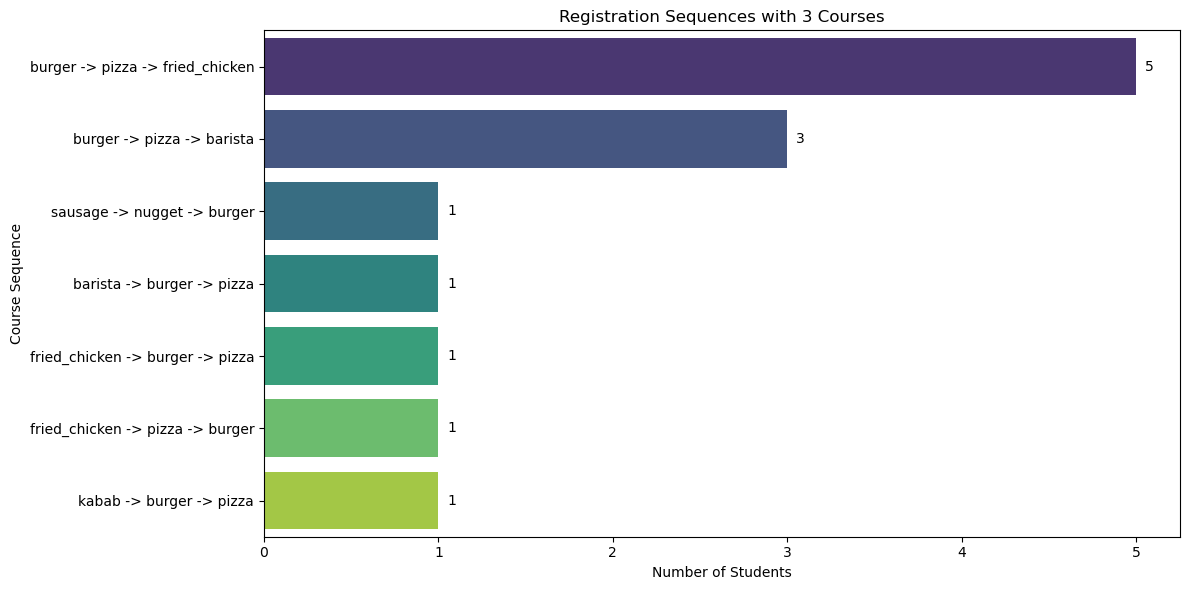

In [30]:
# For each sequence length (number of courses taken by a student)
for length in sorted(multi_seq['seq_length'].unique()):
    
    # Filter students with current sequence length
    sub = multi_seq[multi_seq['seq_length'] == length]

    # Count unique course sequences and number of students for each
    patterns = sub['course_sequence'].value_counts().reset_index()
    patterns.columns = ['sequence', 'student_count']

    # Print summary table
    print(f'---- Sequences with {length} Courses ----')
    print(patterns)

    # Plot bar chart of sequences with this length
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=patterns, y='sequence', x='student_count', palette='viridis')
    plt.title(f'Registration Sequences with {length} Courses')
    plt.xlabel('Number of Students')
    plt.ylabel('Course Sequence')
    plt.tight_layout()

    # Add data labels
    for p in ax.patches:
        plt.text(p.get_width() + 0.05, p.get_y() + p.get_height()/2, int(p.get_width()), va='center')
    
    plt.show()

In [31]:
# Build the course sequence for each student as a list (not a string)
student_paths = df_sorted.groupby('student_id')['course_type'].apply(list)

# Count transitions between consecutive courses (edges)
edges = Counter()
for path in student_paths:
    if len(path) > 1:
        for i in range(len(path)-1):
            edge = (path[i].strip().lower(), path[i+1].strip().lower())  # Remove spaces and convert to lowercase
            edges[edge] += 1

# Convert transition data to a DataFrame
edges_df = pd.DataFrame([(src, dst, weight) for (src, dst), weight in edges.items()],
                        columns=['from', 'to', 'weight']).sort_values('weight', ascending=False).reset_index(drop=True)
edges_df

,from,to,weight
0,burger,pizza,31
1,sausage,nugget,6
2,pizza,fried_chicken,5
3,pizza,barista,3
4,nugget,sausage,2
5,nugget,burger,2
6,kabab,kabab,2
7,barista,cake,1
8,pizza,kabab,1
9,barista,bread,1


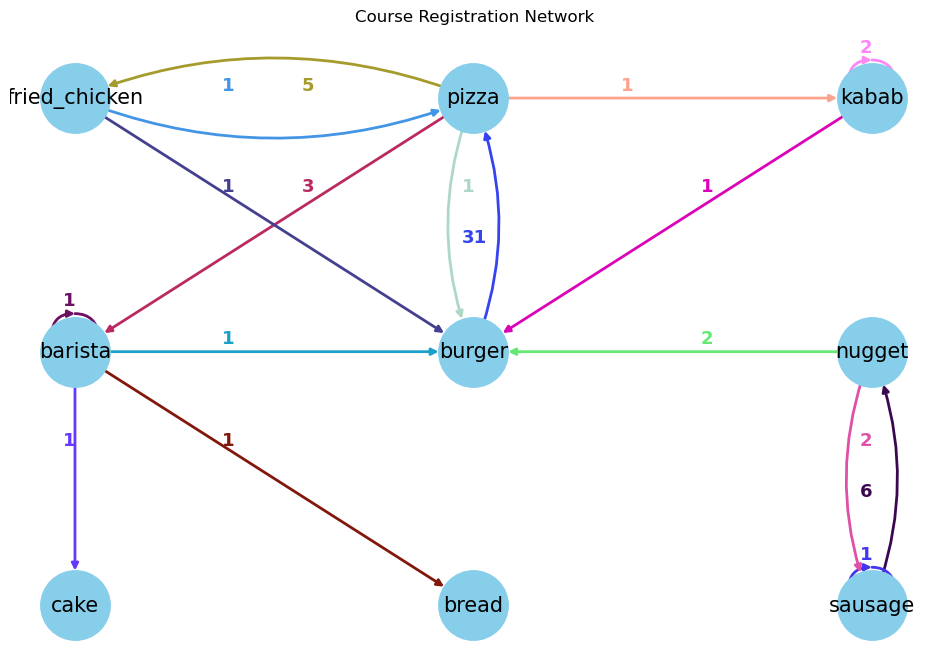

In [32]:
# Build a directed graph from the DataFrame
G = nx.DiGraph()
for _, row in edges_df.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'])

# Set fixed seed for reproducible random colors
random.seed(42)

# Generate a random color for each edge
all_edges = list(G.edges())
colors = []
for _ in all_edges:
    # Random color (RGB)
    color = (random.random(), random.random(), random.random())
    colors.append(color)
    
# Set custom node positions
pos = {
    'fried_chicken': (0, 2),
    'pizza': (1, 2),
    'kabab': (2, 2),
    'barista': (0, 1),
    'burger': (1, 1),
    'nugget': (2, 1),
    'cake': (0, 0),
    'bread': (1, 0),
    'sausage': (2, 0)
}

# Create the plot
plt.figure(figsize=(12, 8))

# Draw nodes and their labels
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=15)

# Draw edges with weight labels and optional curvature for bidirectional edges
for idx, (u, v) in enumerate(G.edges()):
    color = (random.random(), random.random(), random.random())
    
    # Add curvature for bidirectional edges
    if G.has_edge(v, u):
        conn_style = "arc3,rad=0.2"
    else:
        conn_style = "arc3,rad=0.0"
    
    # Draw the edge
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        arrows=True, width=2,
        connectionstyle=conn_style, arrowsize=10, min_source_margin=20, min_target_margin=25,
        edge_color=[color]
    )
    
    # Position and draw the edge weight label
    label_pos = 0.4
    label = G[u][v]['weight']
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    lx = x1 + (x2 - x1) * label_pos - 0.03
    ly = y1 + (y2 - y1) * label_pos + 0.03
    if u == v:
        ly += 0.15
    plt.text(lx, ly, str(label), fontsize=13, color=color, fontweight='bold')

plt.title('Course Registration Network')
plt.axis('off')
plt.show()

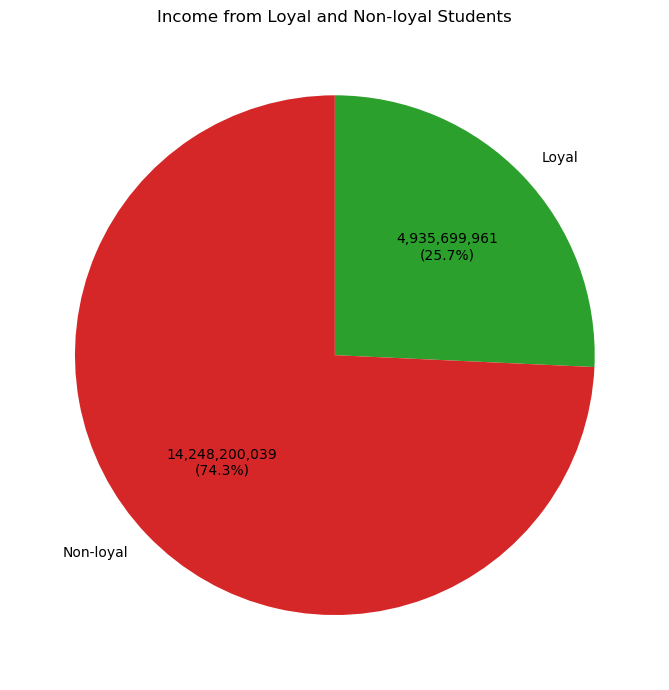

In [33]:
# Find loyal and non-loyal students
loyal_ids = student_counts[student_counts > 1].index       # Loyal
one_time_ids = student_counts[student_counts == 1].index   # One-time only

# Separate data for each group
df_loyal = df[df['student_id'].isin(loyal_ids)]
df_onetime = df[df['student_id'].isin(one_time_ids)]

# Total income for each group
loyal_income = df_loyal['amount_irr'].sum()
onetime_income = df_onetime['amount_irr'].sum()

# Prepare data for pie chart
labels = ['Loyal', 'Non-loyal']
incomes = [loyal_income, onetime_income]

# Function to display both absolute value and percentage in pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val:,}\n({pct:.1f}%)'
    return my_autopct

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(
    incomes,
    labels=labels,
    autopct=make_autopct(incomes),
    startangle=90,
    colors=['#2ca02c','#d62728'],
    counterclock=False
)
plt.title('Income from Loyal and Non-loyal Students')
plt.tight_layout()
plt.show()

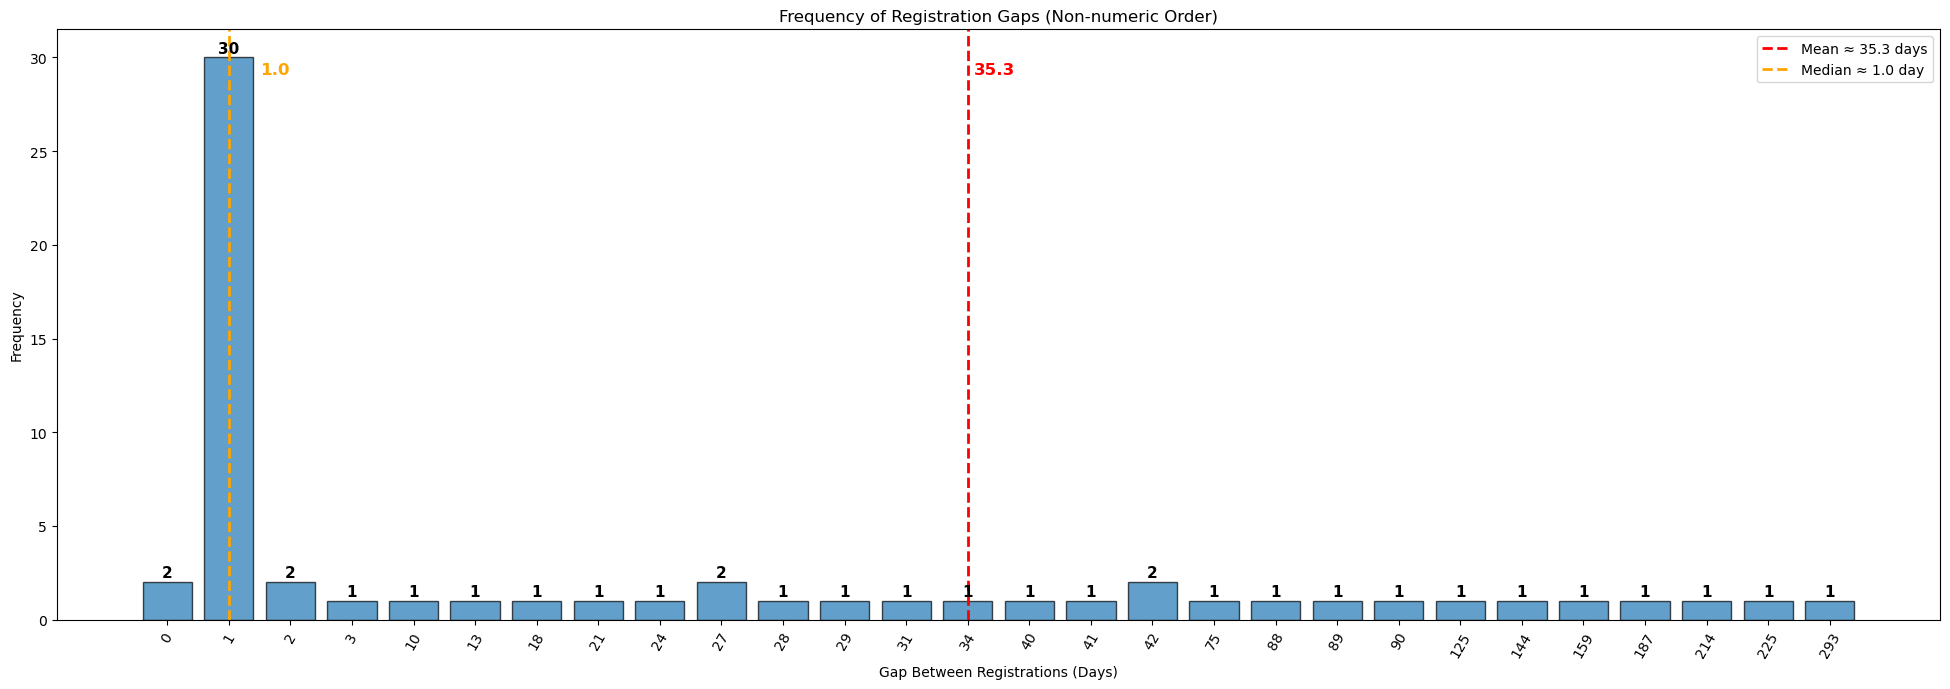

In [34]:
# Filter only students with more than one registration
multi_students = df_sorted['student_id'].value_counts()
multi_students = multi_students[multi_students > 1].index
df_multi = df_sorted[df_sorted['student_id'].isin(multi_students)]

# Calculate time gaps (in days) between registrations for each student
gaps = []
for student, group in df_multi.groupby('student_id'):
    dates = group['course_date'].sort_values().tolist()
    if len(dates) > 1:
        for i in range(1, len(dates)):
            gap = (dates[i] - dates[i-1]).days
            gaps.append(gap)

# Count frequency of each gap value
gap_counts = Counter(gaps)
xs = sorted([x for x, y in gap_counts.items() if y > 0])  # Only gaps that actually occurred
ys = [gap_counts[x] for x in xs]

# Plot histogram (bar chart) of registration gaps
plt.figure(figsize=(min(20, len(xs)*0.7), 7))
bars = plt.bar(range(len(xs)), ys, color='#1f77b4', edgecolor='black', alpha=0.7)

plt.xlabel('Gap Between Registrations (Days)')
plt.ylabel('Frequency')
plt.title('Frequency of Registration Gaps (Non-numeric Order)')
plt.xticks(range(len(xs)), xs, rotation=60)

# Number above each bar
for idx, y in enumerate(ys):
    plt.text(idx, y + 0.1, str(y), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Compute mean and median gap
mean_gap = np.mean(gaps)
median_gap = np.median(gaps)

# Find the index of the closest gap to the mean and median
mean_idx = np.argmin([abs(x - mean_gap) for x in xs])
median_idx = np.argmin([abs(x - median_gap) for x in xs])

# Draw a red dashed line at the mean
plt.axvline(mean_idx, color='red', linestyle='--', linewidth=2, label=f'Mean ≈ {mean_gap:.1f} days')

# Draw a orange dashed line at the median
plt.axvline(median_idx, color='orange', linestyle='--', linewidth=2, label=f'Median ≈ {median_gap:.1f} day')
#plt.text(median_idx + 0.1, max(ys)*0.85, f'{median_gap:.1f}', color='orange', fontsize=12, fontweight='bold')

# Write the mean value on the line
plt.text(mean_idx + 0.1, max(ys)*0.97, f'{mean_gap:.1f}', color='red', fontsize=12, fontweight='bold')
plt.text(median_idx + 0.5, max(ys)*0.97, f'{median_gap:.1f}', color='orange', fontsize=12, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Get each student's first region based on their earliest course date
student_region = df.sort_values(['student_id', 'course_date']).groupby('student_id')['region_group'].first().reset_index()

# Specify whether each student is loyal or not
student_region['is_loyal'] = student_region['student_id'].isin(loyal_ids)

# Group by region to calculate loyalty metrics
region_grouped = student_region.groupby('region_group')['is_loyal'].agg(['count', 'sum'])

# Compute loyalty rate as percentage
region_grouped['loyalty_rate'] = 100 * region_grouped['sum'] / region_grouped['count']

# Rename columns for clarity
region_grouped = region_grouped.rename(columns={
    'count': 'Total Students',
    'sum': 'Loyal Students',
    'loyalty_rate': 'Loyalty Rate (%)'
})

print(region_grouped.sort_values('Loyal Students', ascending=False))

                            Total Students  Loyal Students  Loyalty Rate (%)
region_group                                                                
shiraz                                 169              21         12.426036
fars                                    53              13         24.528302
hormozgan                               11               4         36.363636
unknown                                 32               4         12.500000
bushehr                                 11               2         18.181818
kohgiluyeh\nand boyerahmad               6               2         33.333333
abroad                                   1               1        100.000000
kerman                                   4               1         25.000000
golestan                                 1               0          0.000000
khuzestan                                3               0          0.000000
yazd                                     1               0          0.000000

In [36]:
# Build the course basket for each student (set to remove duplicates)
student_baskets = df.groupby('student_id')['course_type'].apply(lambda x: set(x)).reset_index()

# Extract all pairs for each basket
all_pairs = []
for basket in student_baskets['course_type']:
    if len(basket) > 1:
        for pair in combinations(sorted(basket), 2):
            all_pairs.append(pair)

# Count the frequency of each pair
pair_counts = Counter(all_pairs)
pair_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count']).sort_values('Count', ascending=False)
print(pair_df)

                       Pair  Count
5           (burger, pizza)     32
0         (nugget, sausage)      8
9   (burger, fried_chicken)      7
10   (fried_chicken, pizza)      7
7         (barista, burger)      4
8          (barista, pizza)      4
1          (burger, nugget)      2
4            (kabab, pizza)      2
2         (burger, sausage)      1
3           (barista, cake)      1
6          (barista, bread)      1
11          (burger, kabab)      1


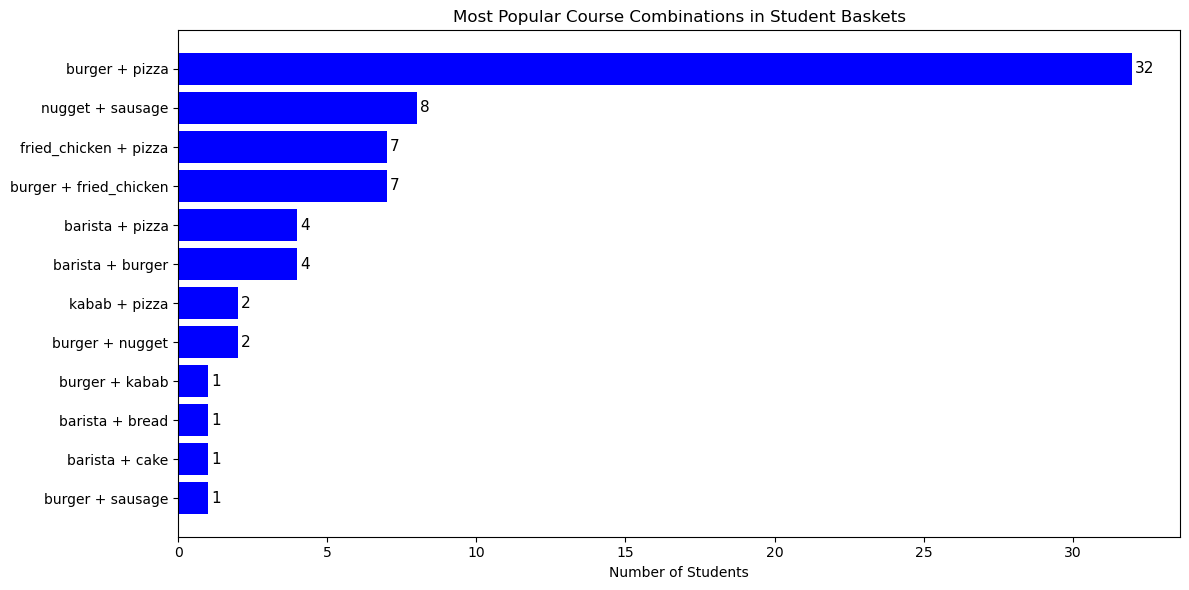

In [37]:
# Prepare course pair labels for plotting
top_pairs = pair_df.sort_values('Count', ascending=True)  # Sort by frequency
labels = [f"{a} + {b}" for a, b in top_pairs['Pair']]

# Plot horizontal bar chart of course pair frequencies
plt.figure(figsize=(12,6))
plt.barh(labels, top_pairs['Count'], color='blue')
plt.xlabel('Number of Students')
plt.title('Most Popular Course Combinations in Student Baskets')
plt.tight_layout()

# Annotate bars with count values
for i, v in enumerate(top_pairs['Count']):
    plt.text(v + 0.1, i, str(v), va='center', fontsize=11)

plt.show()